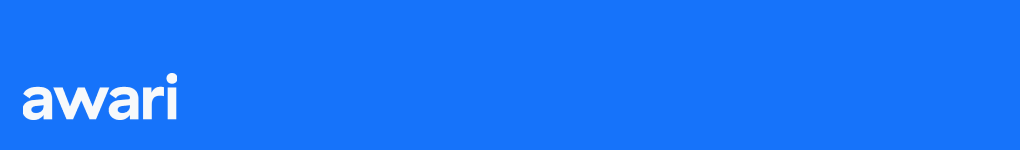

Prática da **Aula 08: Estatística Descritiva I**, do curso de **Data Science** da **[Awari](https://awari.com.br/)**. Para utilizá-la, vá no menu "Arquivo" e, em seguida, na opção "Salvar uma cópia no Drive". Isto criará uma cópia deste notebook em uma pasta chamada "Colab Notebooks", no seu Google Drive pessoal. Use a cópia para criar novas células de código ou executar as células desta prática.

---

# **Análise de Preços de Carros**

## **Objetivo**

Esta é uma prática complementar, que poderá ser vista na 8ª aula do curso de Data Science, caso haja tempo.

Ela é similar a outra prática baseada em dados do Spotify. Será usada uma base de dados de preços de carros, baseados na Tabela Fipe, para a demonstração.

Os dados são de 2017, mas não comprometem a análise. O objetivo, aqui, não é fazer uma análise de dados atuais, mas, sim, demonstrar técnicas estatísticas aplicáveis a quaisquer conjuntos de dados.

## **Prática**

### **Preparativos**

In [ ]:
import numpy
import pandas
import seaborn

from matplotlib import pyplot
%matplotlib inline

from scipy import stats

### **Carregando os dados**

Primeiro, faça download do arquivo [fipe_price_list_201710.csv](https://drive.google.com/file/d/1LFe4C4aNTL8LEM6FovkrhTgBtXwVoNff/view?usp=share_link) e, em seguida, faça upload do mesmo para a pasta raiz do seu Google Drive.

Depois, monte o drive para poder importar o arquivo, conforme as etapas a seguir:

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

A seguir, carregamos os dados da tabela de preços e separamos modelos e versões de modelos dos carros:

In [ ]:
prices = pandas.read_csv('/content/drive/MyDrive/fipe_price_list_201710.csv', index_col=[0])

# Major maker
major_makers = ['Mercedes-Benz', 'BMW', 'Audi', 'VW - Volkswagen', 'Fiat',
                'GM - Chevrolet', 'Kia Motors', 'Hyundai', 'Ford', 'Citroën',
                'Renault']
prices['maker_name_major'] = prices['maker_name'].map(lambda x: x
                                                      if x in major_makers else
                                                      '_outros_')

# Model and version
model_version = prices.model_name.str.split(' ', 1)
prices['model_name'] = model_version.str[0]
prices['model_version'] = model_version.str[1]

In [ ]:
prices.head()

In [ ]:
prices.describe()

### **Modelos por marca**

In [ ]:
prices_by_models = prices.groupby(['maker_name', 'model_name'])\
    ['price'].agg(['min', 'mean', 'max', 'std'])
prices_by_models.reset_index(level=1, inplace=True)
prices_by_models.head()

In [ ]:
models_by_maker = prices_by_models.pivot_table(index=['maker_name'],
                                               values='model_name',
                                               aggfunc='count')
models_by_maker.sort_values(by='model_name', ascending=False, inplace=True)
models_by_maker.head()

In [ ]:
ax = models_by_maker.plot.bar(legend=False, figsize=[11, 5])
ax.figure.tight_layout()

In [ ]:
prices_by_models = prices.groupby(['maker_name', 'model_name', 'build_year'])\
    ['price'].agg(['min', 'mean', 'max', 'std'])
prices_by_models.reset_index(level=[2, 1], inplace=True)
prices_by_models.head()

In [ ]:
models_by_maker = prices_by_models.pivot_table(index=['maker_name'],
                                               values='model_name',
                                               columns=['build_year'],
                                               aggfunc='count')
models_by_maker.head()

In [ ]:
models_by_maker_today = models_by_maker[32000].sort_values(ascending=False)
ax = models_by_maker_today[models_by_maker_today>0].plot.bar(legend=False,
                                                             figsize=[11, 5])
ax.figure.tight_layout()

In [ ]:
#...:....|....:....|....:....|....:....|....:....|....:....|....:....|....:....|
prices_by_models_major = prices.groupby(['maker_name_major', 'model_name',
                                         'build_year'])['price'].agg(['min', 'mean',
                                                                      'max', 'std'])
prices_by_models_major.reset_index(level=2, inplace=True)
prices_by_models_major.head()

In [ ]:
#...:....|....:....|....:....|....:....|....:....|....:....|....:....|....:....|
models_by_maker_major = prices_by_models_major\
    [prices_by_models_major.build_year < 32000].pivot_table(
        index='build_year', columns=['maker_name_major'],  values='mean',
        aggfunc='count')
models_by_maker_major.head()

In [ ]:
colors = pyplot.cm.tab20c(numpy.linspace(0, 1, 11))
models_by_maker_major.plot.area(figsize=[11, 5], color=colors)

### **Versões por marca**

Estamos analisando desde 1985:

In [ ]:
ptable_versions = prices.pivot_table(index=['maker_name'], values='model_name',
                                     aggfunc=len)
ptable_versions.sort_values(by='model_name', ascending=False, inplace=True)

In [ ]:
ax = ptable_versions.plot.bar(legend=False, figsize=[11, 5])
ax.figure.tight_layout()

Considerando-se apenas carros novos (0 km):

In [ ]:
ptable_versions_new = prices[prices.build_year==32000].pivot_table(
    index=['maker_name'], values='model_name', aggfunc=len)
ptable_versions_new.sort_values(by='model_name', ascending=False, inplace=True)

In [ ]:
ax = ptable_versions_new.plot.bar(legend=False, figsize=[11, 5])
ax.figure.tight_layout()

Ao longo do tempo, quantas versões de carros há no mercado?

In [ ]:
ptable_model_version = prices.pivot_table(index=['maker_name', 'model_name'],
                                          columns='build_year',
                                          values='model_version', aggfunc=len)

In [ ]:
ptable_model_version.head()

In [ ]:
version_timeseries = ptable_model_version.sum()
version_timeseries[version_timeseries.index < 32000].plot.line(figsize=[11, 5])

### **Distribuição de preços**

In [ ]:
bins = numpy.arange(0, 300e3, 1e3)
ax = prices['price'].plot.hist(bins=bins, legend=False, figsize=[11, 5],
                               linewidth=0, density=True, histtype='stepfilled')

#### **Distribuição gaussiana intertida**

Aplicando [Inverse gaussian distribution](https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution):

\begin{equation}
    f(x\;|\;\mu, \lambda) = \sqrt{\frac{\lambda}{2\pi x^3}} e^{-\frac{\lambda(x - \mu)^2}{2 \mu^2 x}}
\end{equation}

In [ ]:
ax = prices['price'].plot.hist(bins=bins, legend=False, figsize=[11, 5],
                               linewidth=0, density=True, histtype='stepfilled')

mean, median = prices.price.mean(), prices.price.median()
mode = prices.price.mode().values[0]
ax.axvline(mean)
ax.text(mean+2500, 2e-5, 'Media={:.0f}'.format(mean))
ax.axvline(median)
ax.text(median+2500, 1.8e-5, 'Mediana={:.0f}'.format(median))
ax.axvline(mode)
ax.text(mode+2500, 1.6e-5, 'Moda={:.0f}'.format(mode))

mu, loc, scale = stats.invgauss.fit(prices['price'])
x = 0.5 * (bins[1:] + bins[:-1])  # Center of the bins
pdf = stats.invgauss.pdf(x, mu, loc, scale)
ax.plot(x, pdf, 'r')
ax.annotate('{:.0f}'.format(scale/mu), xy=(scale/mu, 2.45e-5), xycoords='data',
                xytext=(30, 10), textcoords='offset points',
                fontsize='12', fontstretch='ultra-condensed',
                ha='center', va='bottom',
                arrowprops=dict(arrowstyle="-",
                                connectionstyle='arc3,rad=0.3',
                                color='#999999')
           )

In [ ]:
ax = prices['price'][prices.build_year == 32000].plot.hist(
    bins=bins, legend=False, figsize=[11, 5], linewidth=0,
    histtype='stepfilled')

In [ ]:
prices.where(prices.build_year < 32000)\
    .plot.scatter('build_year', 'price', figsize=[11, 5])

In [ ]:
ax = prices.boxplot(column='price', by='build_year', rot=45, figsize=[11, 5],
                    grid=False)
ax.set_ylim([0, 5e5])
ax.figure.suptitle('')
ax.figure.tight_layout()

In [ ]:
ptable = prices.pivot_table(values='price', index=['maker_name', 'model_name',
                                                   'fuel_type'],
                            columns=['build_year'])
ptable.describe()

In [ ]:
fig = pyplot.figure(figsize=[9, 200])
ax = seaborn.heatmap(ptable, square=False, cmap='viridis', linewidths=0.1,
                     linecolor='#cccccc', vmin=0, vmax=200e3,
                     cbar_kws=dict(orientation='horizontal', extend='max',
                                   pad=0.0045, aspect=40))
fig.tight_layout()

### **Desvalorização ao deixar a concessionária**

In [ ]:
def get_almost_new(df):
    if not pandas.isnull(df[2018]):
        return df[2018]
    elif not pandas.isnull(df[2017]):
        return df[2017]
    elif not pandas.isnull(df[2016]):
        return df[2016]
    else:
        return numpy.nan


prices_ptable = prices.where(prices.build_year >= 2016)\
    .pivot_table(values='price', columns=['build_year'],
                 index=['maker_name', 'model_name', 'fipe_code'], aggfunc=sum)
prices_ptable['almostnew'] = [get_almost_new(prices_ptable.iloc[n]) for n
                                  in range(len(prices_ptable))]
prices_ptable['rel_devaluation'] = 1 - (prices_ptable['almostnew'] /
                                    prices_ptable[32000])

ax = prices_ptable.plot.scatter([32000], 'rel_devaluation', logx=True,
                                figsize=[11, 5], by='maker_name')
ax.set_xlabel('')
ax.figure.tight_layout()

In [ ]:
ax = prices_ptable.boxplot(column='rel_devaluation', by='maker_name', rot=90,
                           grid=False, figsize=[11, 5])
ax.figure.suptitle('')
ax.figure.tight_layout()

---

Notebook utilizado para fins educacionais da **Awari**.

**© AWARI. Todos os direitos reservados.**